In [1]:
%matplotlib widget
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.signal import find_peaks

# 设置中文字体为 wqy
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']  # 使用文泉驿正黑字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [2]:
def calculate_threshold(red_channel, mask = None):
    if mask is not None:
        red_channel = cv.bitwise_and(red_channel, red_channel, mask=mask)
    hist = cv.calcHist([red_channel], [0], None, [256], [0, 256]).flatten()
    hist[0] = 0
    peaks, _ = find_peaks(hist)
    sorted_peaks = sorted(peaks, key=lambda x: hist[x], reverse=True)
    second_peak_index = sorted_peaks[1]
    min_val_after_peak = np.argmin(hist[second_peak_index:]) + second_peak_index
    return min_val_after_peak


def segment_image(src, threshold, kernel_size):
    _, src_bin = cv.threshold(src, threshold, 255, cv.THRESH_BINARY)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, kernel_size)
    src_bin = cv.morphologyEx(src_bin, cv.MORPH_OPEN, kernel)
    src_bin = cv.morphologyEx(src_bin, cv.MORPH_CLOSE, kernel)
    coords = cv.findNonZero(src_bin)
    contours, _ = cv.findContours(src_bin, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        return cv.boundingRect(coords), None
    contour = max(contours, key=cv.contourArea)
    mask = np.zeros(src.shape, dtype=np.uint8)
    cv.drawContours(mask, [contour], -1, 1, thickness=cv.FILLED)
    return cv.boundingRect(coords), mask


def crop_to_bbox(frame, bbox):
    x, y, w, h = bbox
    return frame[y : y + h, x : x + w]


def read_frame(video_path, frame_number):
    cap = cv.VideoCapture(video_path)
    cap.set(cv.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError(f"Could not read frame {frame_number}")
    return frame


def process_frame(frame, kernel_size=(9, 9)):
    red_channel = frame[:, :, 2]
    threshold = calculate_threshold(red_channel)

    bbox, mask = segment_image(red_channel, threshold, (5, 5))
    red_channel = crop_to_bbox(red_channel, bbox)
    mask = crop_to_bbox(mask, bbox)

    threshold = calculate_threshold(red_channel, mask)
    _, binary_image = cv.threshold(red_channel, threshold, 255, cv.THRESH_BINARY_INV)

    kernel = cv.getStructuringElement(cv.MORPH_RECT, kernel_size)
    processed_image = cv.morphologyEx(binary_image, cv.MORPH_OPEN, kernel)
    processed_image = cv.morphologyEx(processed_image, cv.MORPH_CLOSE, kernel)

    edges = cv.Canny(processed_image, 50, 150)
    contours, _ = cv.findContours(edges, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    min_length = 500  # 设置最小长度阈值
    max_radius = min(bbox[2:]) // 2
    max_area = np.pi * (max_radius ** 2)
    circularity_threshold = 0.5 # 设置圆形度阈值

    # 在 cropped_frame 上绘制过滤后的轮廓
    cropped_frame = crop_to_bbox(frame, bbox)

    for contour in contours:
        area = cv.contourArea(contour)
        perimeter = cv.arcLength(contour, True)
        if perimeter < min_length or area > max_area:
            continue
        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        if circularity >= circularity_threshold:
            color = classify_contour_by_circle(contour, binary_image)
            cv.drawContours(cropped_frame, [contour], -1, color, 10)
    return cropped_frame, binary_image, processed_image, edges


def classify_contour_by_circle(contour, binary_image, thickness = 20):
    # 创建与 binary_image 大小相同的掩码
    mask = np.zeros_like(binary_image)
    cv.drawContours(mask, [contour], -1, 255, thickness)

    # 创建轮廓内涂满的图像
    filled_contour_image = np.zeros_like(binary_image)
    cv.drawContours(filled_contour_image, [contour], -1, 255, thickness=cv.FILLED)

    # 获取在掩码图像和轮廓内涂满的图像中都为255的点
    combined_mask = cv.bitwise_and(mask, filled_contour_image)

    # 获取这些点在原来的二值化图像中的颜色
    masked_points = binary_image[combined_mask == 255]

    # 计算这些点的像素平均值
    avg_color = np.mean(masked_points)

    # 根据平均值分类
    if avg_color < 128:
        color = (0, 255, 0)  # 绿色
    elif avg_color > 128:
        color = (255, 0, 0)  # 蓝色
    else:
        color = (255, 255, 255)  # 白色

    return color


def display_images(images):
    plt.close()
    _, axes = plt.subplots(1, 4, figsize=(12, 4))
    for ax, img in zip(axes, images):
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.show()

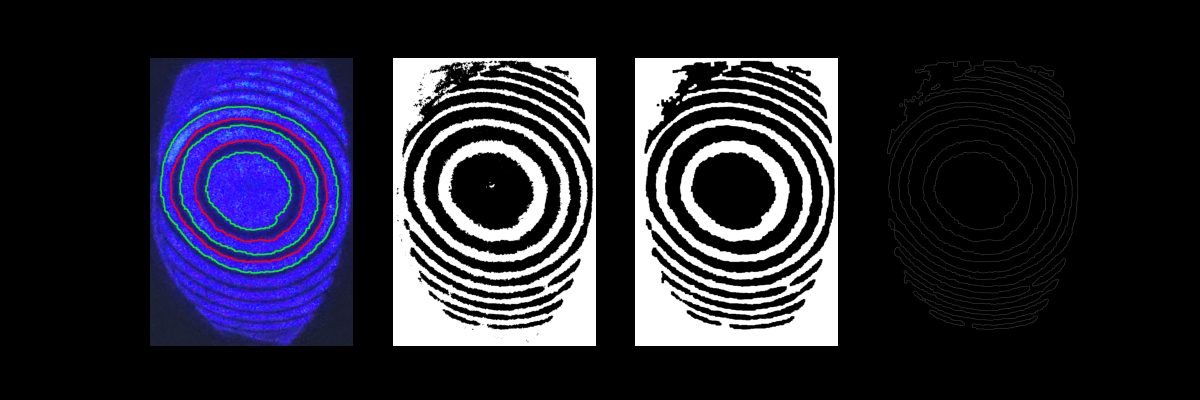

In [3]:
video_path = "真实场景.mp4"
frame_number = 41
frame = read_frame(video_path, frame_number)
images = process_frame(frame, (13, 13))
display_images(images)

In [21]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


def save_image(image, filename):
    cv.imwrite(filename, image)


def save_edges_image(edges, filename, dilation_size=3):
    # 扩展边缘的粗细
    kernel = np.ones((dilation_size, dilation_size), np.uint8)
    dilated_edges = cv.dilate(edges, kernel, iterations=1)

    # 创建一个白色背景的图像
    white_background = np.ones_like(dilated_edges) * 255
    # 将边缘部分设置为黑色
    white_background[dilated_edges == 255] = 0

    # 保存图像
    save_image(white_background, filename)


def process_and_save_images(video_path, frame_number, kernel_size=(9, 9)):
    plt.close("all")
    frame = read_frame(video_path, frame_number)

    # 保存原始图像
    save_image(frame, "original_frame.png")

    red_channel = frame[:, :, 2]
    threshold = calculate_threshold(red_channel)

    bbox, mask = segment_image(red_channel, threshold, (5, 5))
    red_channel_cropped = crop_to_bbox(red_channel, bbox)
    mask_cropped = crop_to_bbox(mask, bbox)

    # 在原始图像上绘制白色方框
    frame_with_bbox = frame.copy()
    x, y, w, h = bbox
    cv.rectangle(frame_with_bbox, (x, y), (x + w, y + h), (255, 255, 255), 20)

    # 保存原始图像（带白色方框）
    save_image(frame_with_bbox, "original_frame_with_bbox.png")

    threshold = calculate_threshold(red_channel_cropped, mask_cropped)
    _, binary_image = cv.threshold(
        red_channel_cropped, threshold, 255, cv.THRESH_BINARY_INV
    )

    # 保存原始的逆二值化图像
    save_image(binary_image, "binary_image.png")

    kernel = cv.getStructuringElement(cv.MORPH_RECT, kernel_size)
    processed_image = cv.morphologyEx(binary_image, cv.MORPH_OPEN, kernel)
    processed_image = cv.morphologyEx(processed_image, cv.MORPH_CLOSE, kernel)

    # 保存形态学操作后的逆二值化图像
    save_image(processed_image, "processed_image.png")

    edges = cv.Canny(processed_image, 50, 150)

    # 保存边缘图像（白色背景，黑色边缘）
    save_edges_image(edges, "edges_image.png")


    contours, _ = cv.findContours(edges, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    min_length = 500  # 设置最小长度阈值
    max_radius = min(bbox[2:]) // 2
    max_area = np.pi * (max_radius**2)
    circularity_threshold = 0.5  # 设置圆形度阈值

    cropped_frame = crop_to_bbox(frame, bbox)

    # 保存有效区域
    save_image(cropped_frame, "valid_area.png")

    for contour in contours:
        area = cv.contourArea(contour)
        perimeter = cv.arcLength(contour, True)
        if perimeter < min_length or area > max_area:
            continue
        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        if circularity >= circularity_threshold:
            color = classify_contour_by_circle(contour, binary_image)
            cv.drawContours(cropped_frame, [contour], -1, color, 10)

    # 保存最终的cropped_frame
    save_image(cropped_frame, "cropped_frame.png")


# 调用函数处理并保存图像
video_path = "真实场景.mp4"
frame_number = 41
process_and_save_images(video_path, frame_number, (13, 13))

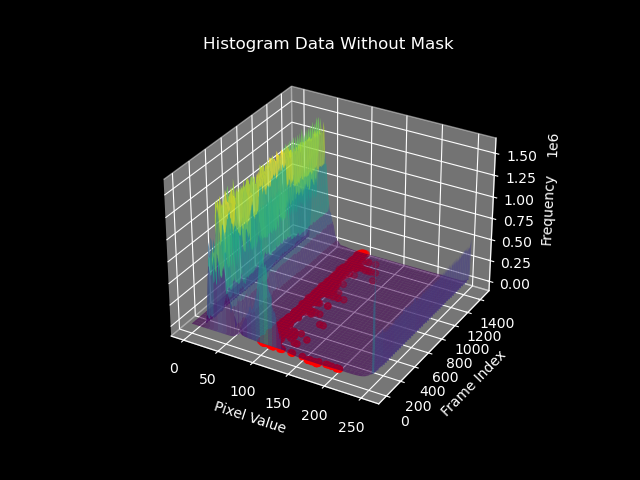

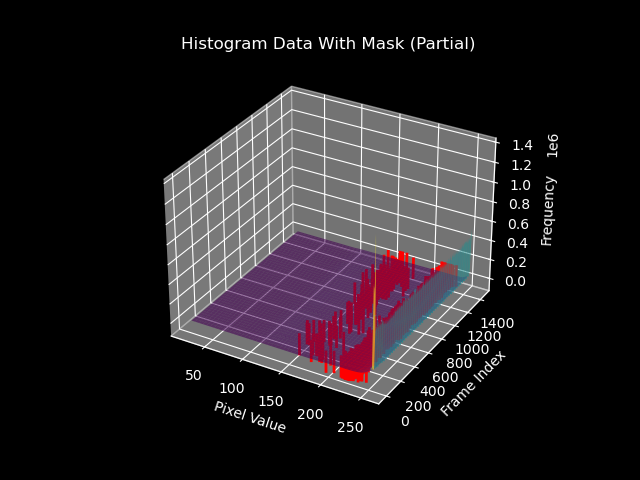

In [1]:
%matplotlib widget

%matplotlib widget

import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def read_csv(file_path):
    data = []
    thresholds = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            data.append([int(value) for value in row[:-1]])
            thresholds.append(int(row[-1]))
    return np.array(data), np.array(thresholds)

def plot_3d(data, thresholds, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x = np.arange(data.shape[1])
    y = np.arange(data.shape[0])
    x, y = np.meshgrid(x, y)
    z = data

    ax.plot_surface(x, y, z, cmap='viridis', alpha=0.6)  # 设置透明度
    ax.set_xlabel('Pixel Value')
    ax.set_ylabel('Frame Index')
    ax.set_zlabel('Frequency')
    ax.set_title(title)

    # 绘制阈值点
    threshold_x = np.array(thresholds)
    threshold_y = np.arange(len(thresholds))
    threshold_z = np.array([z[i, t] for i, t in enumerate(thresholds)])
    ax.scatter(threshold_x, threshold_y, threshold_z, color='r')

    plt.show()

def plot_3d_partial(data, thresholds, title, start_value=0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 找到最小非零值
    min_nonzero = np.min(np.where(data > 0, np.arange(data.shape[1]), 256))
    start_index = max(min_nonzero, start_value)

    x = np.arange(start_index, data.shape[1])
    y = np.arange(data.shape[0])
    x, y = np.meshgrid(x, y)
    z = data[:, start_index:]

    ax.plot_surface(x, y, z, cmap='viridis', alpha=0.6)  # 设置透明度
    ax.set_xlabel('Pixel Value')
    ax.set_ylabel('Frame Index')
    ax.set_zlabel('Frequency')
    ax.set_title(title)

    # 绘制阈值短线
    threshold_x = np.array([t for t in thresholds if t >= start_index])
    threshold_y = np.arange(len(thresholds))
    threshold_z = np.array([z[i, t - start_index] for i, t in enumerate(thresholds) if t >= start_index])
    for i in range(len(threshold_x)):
        ax.plot([threshold_x[i], threshold_x[i]], [threshold_y[i], threshold_y[i]], [threshold_z[i] - 100000, threshold_z[i] + 100000], color='r', linewidth=2)

    plt.show()

plt.close("all")

# 读取CSV文件
hist_data_no_mask, thresholds_no_mask = read_csv('hist_data_no_mask.csv')
hist_data_with_mask, thresholds_with_mask = read_csv('hist_data_with_mask.csv')

# 绘制三维图
plot_3d(hist_data_no_mask, thresholds_no_mask, 'Histogram Data Without Mask')
plot_3d_partial(hist_data_with_mask, thresholds_with_mask, 'Histogram Data With Mask (Partial)', start_value=0)